## steps
1. Understand the whole picture
   - Quantify final objectives ?
   - What is the current solution (if any) ? Downsides ?
2. Get data
3. explore, visualize data => **insight**
4. prepare data for machine learning algo
5. select model 
6. fine-tune model 
   - Mesure the errors made by the model, with **RMSE** or **MAE**
7. present solution
8.  launch, monitor, maintain system

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("./housing.csv")

In [3]:
display(data.head())
display(data[["ocean_proximity"]].value_counts())
display(data.info())
display(data.describe())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


None

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Get the `feel` of the data with histogram

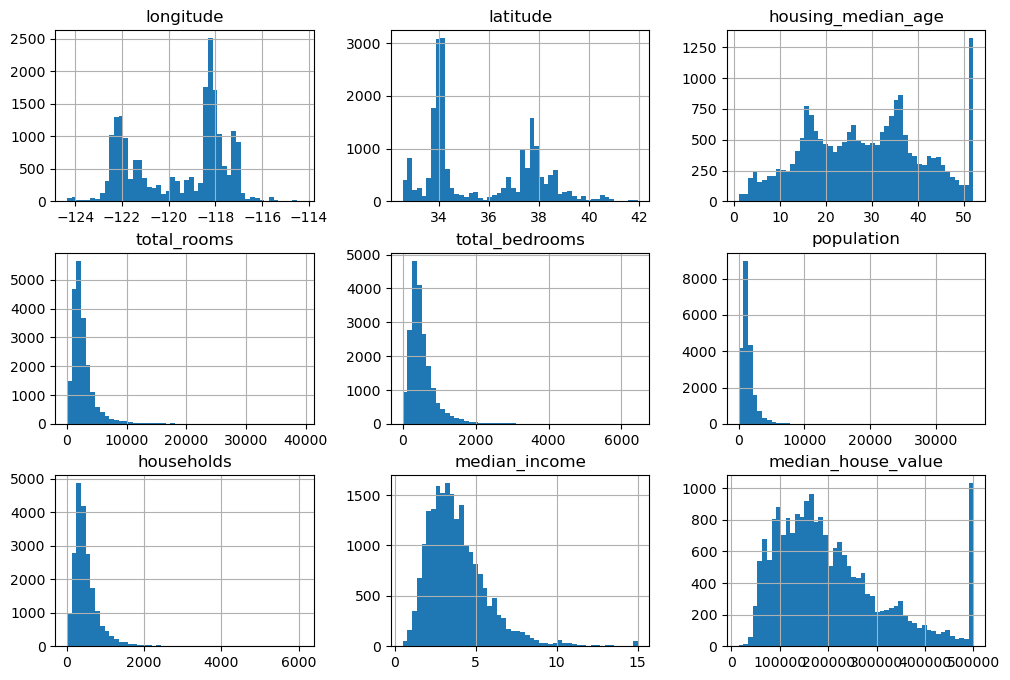

In [4]:
import matplotlib.pyplot as plt

data.hist(bins=50, figsize=(12, 8))
plt.show()

## I. Create `Train/Test` dataset

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
# basic dividing
trainset, testset = train_test_split(data,
                                     test_size=.2,
                                     random_state=44)

- But when **data is updated**, and the train and test dataset is **randomly chosen again**  
    => the **new test set** might contain the **old train data**, *thus vice versa*
- **SOLUTION**:
  - **HASH EACH RECORD** (hash so that it produce a **number identifier**)
  - Sort all record based on the **number identifier**
  - divide train/test set at the **PERCENTILE** 

In [7]:
import numpy as np
from zlib import crc32
from typing import Set
def is_id_in_test_set(identifier, test_ratio) -> bool:
    # crc32 create a hash of 32bit check sum
    #  2**32 is the largest number that this algo create
    # test_ratio is the percentile, determine the hash at that percentile 
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column) -> Set[pd.Series]:
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

### 1. Reset the index, use the `index` as identifier

In [8]:
housing_with_id = data.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

### 2. using `longtitude` and `latitude` as identifier 
* not consistent

In [9]:
housing_with_id["new_id"] = data["longitude"] + data["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "new_id")

In [10]:
display(train_set.shape)
display(data.shape)

(20624, 12)

(20640, 10)

## II. divide the data into many `Strata` (`median_income`)
- to investigate if certain groups (*strata*) of people have special statistic
- Each strata (class) will have the same **data distribution**

### 1. Manually create strata

In [11]:
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                            labels=[1,2,3,4,5]
                            )

<AxesSubplot:>

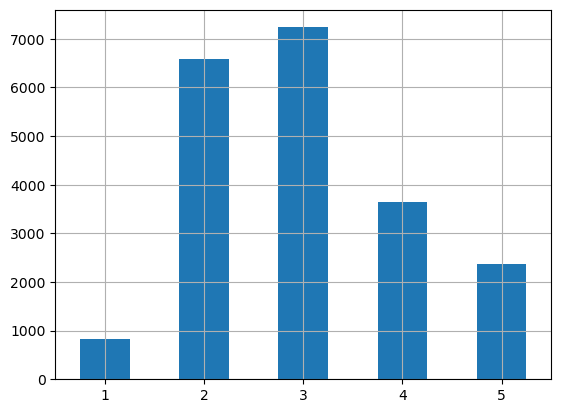

In [12]:
(data["income_cat"] 
 .value_counts()
 .sort_index()
 .plot.bar(rot=0, grid=True)
)

### 2. Create strata with **scikit-learn** 

#### Directly use **StratifiedShuffleSplit** 

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
strat_splits = []
'''
create 10 splits
each split has the same `income_cat` distribution
'''
for train_index, test_index in splitter.split(data, data["income_cat"]):
    print(len(train_index))
    print(len(test_index))
    print("___")
    strat_train_set_n = data.iloc[train_index]
    strat_test_set_n = data.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

16512
4128
___
16512
4128
___
16512
4128
___


#### Use `stratify` option in `train_test_split`  

In [14]:
strat_train_set, strat_test_set = train_test_split(
    data,
    test_size=.2,
    stratify=data["income_cat"],
    random_state=42
)

#### The column `income_cat` is only meant for **stratified sampling**, you can drop it after sampling

In [15]:
strat_test_set.reset_index(drop=True).to_feather("stratified-data/strat_test_set.arrow")
strat_train_set.reset_index(drop=True).to_feather("stratified-data/strat_train_set.arrow")

## III. Explore and **visualize** the data => insights

### Graphical data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

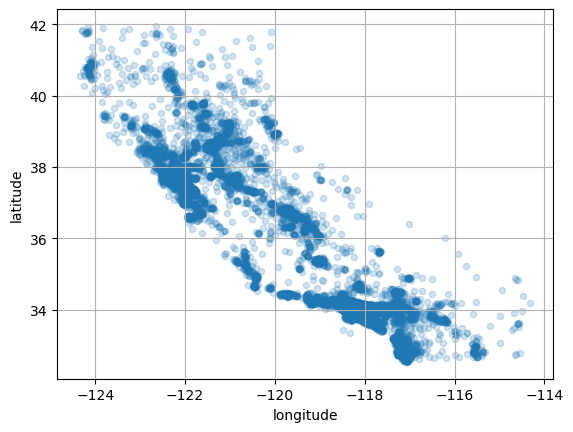

In [16]:
strat_train_set.plot.scatter(
    x="longitude",
    y="latitude",
    grid=True,
    alpha=.2 # set the transperancy of each dot
    # to see the density of data
)

- Embed more info into graphics:
  - Dot Radius represents distric's poputation
  - Color represent price

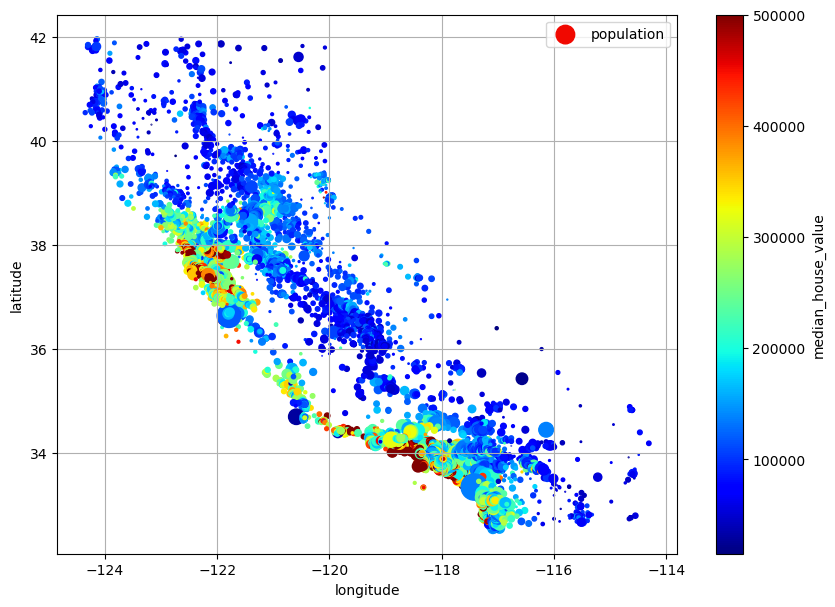

In [19]:
data.plot.scatter(
    x="longitude",
    y="latitude",
    grid=True,
    s=data["population"]/100, # size of each marker
    label = "population",
    c="median_house_value", # column to color-map to
    cmap="jet", # type of color map
    colorbar=True,
    legend=True,
    figsize=(10,7)
)

plt.show()

### Look for correlations

- Calculate pearson coeff of every pair of attribute
  - pearson is for **linear relationship**, and for vars that adhear to the **normal distribution**


In [22]:
corr_matrix = data.corr(numeric_only=True)

In [24]:
corr_matrix["median_house_value"].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

=> **median_income** seams to be the most influential to the **median_house_value**

<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>

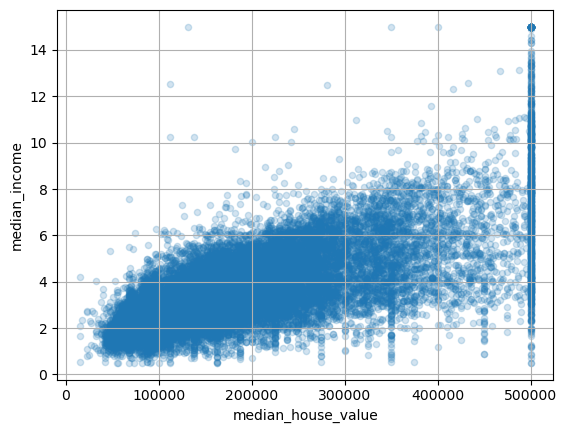

In [26]:
data.plot.scatter(
    x="median_house_value",
    y="median_income",
    alpha=.2,
    grid=True
)